# Land Cover Classification with EuroSAT

## 2020년 08월 31일 안상호

In [1]:
!pwd

/home/jovyan/Land-Cls/02_EuroSAT


In [15]:
import os

# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
from pathlib import Path

# Sangho Workspace|
root_dir = Path("/home/jovyan/")
base_dir = root_dir  / 'Land-Cls'

data_path = base_dir / "data" 

In [3]:
from fastai.vision import *

In [4]:
torch.cuda.device(0)

In [5]:
import torch 

print(torch.cuda.is_available())
torch._C._cuda_getDriverVersion()
# torch.cuda.get_device_name(0)

True


10010

In [6]:
!nvidia-smi

Sun Sep  6 03:58:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.116.00   Driver Version: 418.116.00   CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:0E:00.0 Off |                    0 |
| N/A   37C    P0    38W / 300W |     12MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   37C    P0    37W / 300W |     12MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [7]:
import sys
import os

# Google Colab Version
# sys.path.append(str(base_dir))


# Local Version
PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser("__file__"))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

from utils import preprocess, model #earth

# 1. Training Test

## 1.1. Create Databunch

In [8]:
from fastai.vision import *

path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

In [7]:
src = (ImageList.from_folder(data_path / "eurosat")
       .split_by_rand_pct(0.2)
       .label_from_folder())

In [8]:
data = (src.transform(get_transforms(), size=128)
        .databunch().normalize(imagenet_stats))

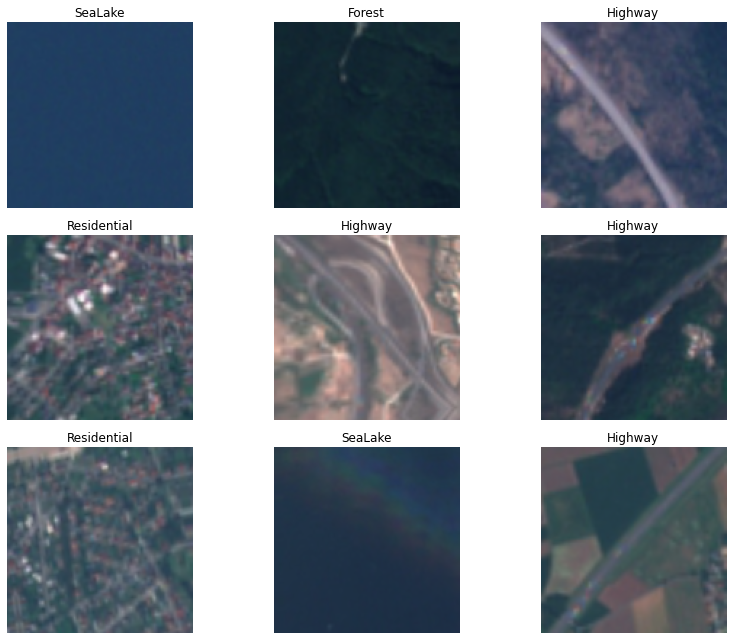

In [27]:
data.show_batch(rows=3, figsize=(12,9))

## 1.2. Create and Train Learner

In [10]:
arch = models.resnet50

learn = cnn_learner(data, arch, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 8.32E-03


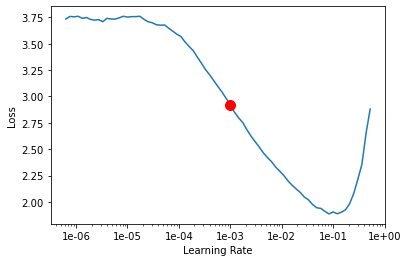

In [11]:
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [13]:
learn.fit_one_cycle(15, 5E-03)

# 2. Experimenting with Class

In [9]:
from sklearn.metrics import f1_score

@np_func
def f1_macro(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='macro')

@np_func
def f1_weighted(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='weighted')

## 2.1. ResNet50

### Pretraining with ImageNet

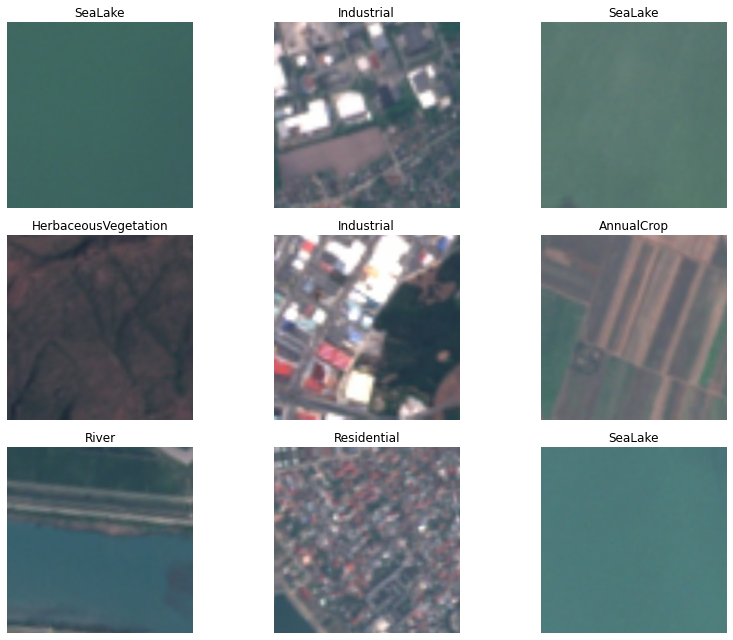

In [32]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : True, 
    "load_dir": None
}

vis = model.FastVision(models.resnet50, parameters, task="classification")
# vis.find_alpha()


In [50]:
vis.fit_model_cyc(15, 5e-03)

In [51]:
vis.learn.save(base_dir / "learn" / "euro-res50-1")

In [12]:
vis.learn.load(base_dir / "learn" / "euro-res50-1")

Learner(data=ImageDataBunch;

Train: LabelList (21600 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
AnnualCrop,AnnualCrop,AnnualCrop,AnnualCrop,AnnualCrop
Path: /home/jovyan/Land-Cls/data/eurosat;

Valid: LabelList (5400 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
HerbaceousVegetation,Industrial,Highway,Industrial,HerbaceousVegetation
Path: /home/jovyan/Land-Cls/data/eurosat;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.63E-06


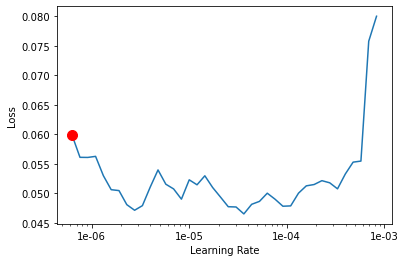

In [13]:
vis.learn.unfreeze()

vis.find_alpha()

In [14]:
vis.learn.fit_one_cycle(10, max_lr=slice(1e-04))
vis.learn.save(base_dir / "learn" / "euro-res50-2")

### Pretraining from Scratch

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 1.45E-02


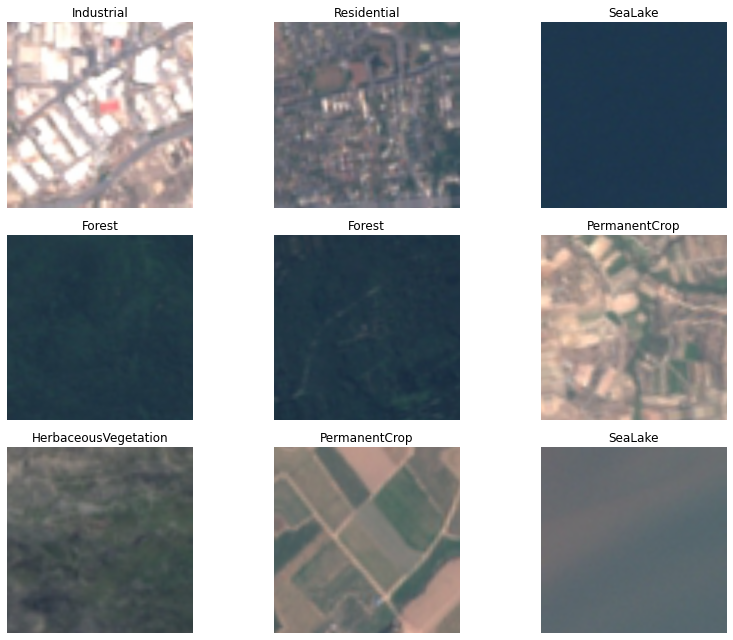

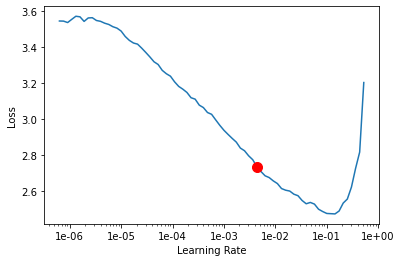

In [23]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : False, 
    "load_dir": None
}

vis = model.FastVision(models.resnet50, parameters, task="classification")
vis.find_alpha()


In [24]:
vis.fit_model_cyc(15, 5e-03)

In [25]:
vis.learn.save(base_dir / "learn" / "euro-res50-r-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 7.59E-08


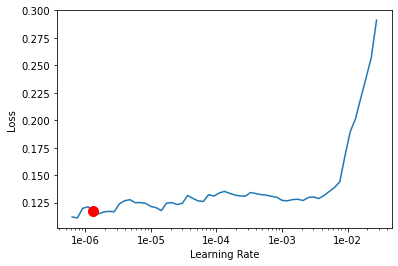

In [26]:
vis.learn.unfreeze()

vis.find_alpha()

In [27]:
vis.learn.fit_one_cycle(10, max_lr=slice(1e-06, 5e-05))
vis.learn.save(base_dir / "learn" / "euro-res50-r-2")

## 2.2. ResNet101

### Pretraining with ImageNet

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 1.20E-02


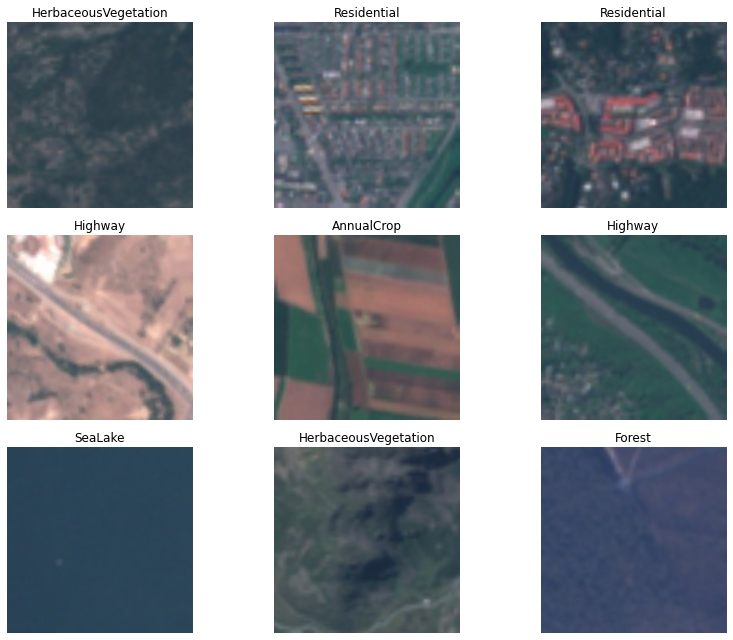

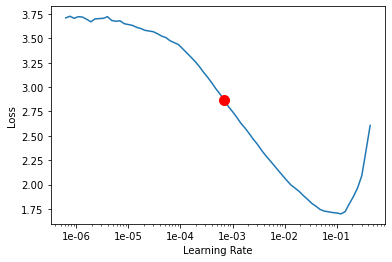

In [44]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : True, 
    "load_dir": None
}

vis = model.FastVision(models.resnet101, parameters, task="classification")
vis.find_alpha()


In [45]:
vis.fit_model_cyc(15, 5e-03)

- 성능 향상을 위한 fine-tunning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 4.79E-07


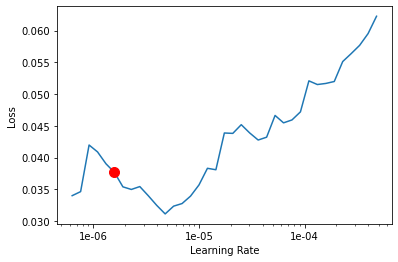

In [46]:
vis.learn.unfreeze()

vis.find_alpha()

In [47]:
vis.fit_model_cyc(15, 1e-05)

In [48]:
vis.learn.save(base_dir / "learn" / "euro-res101")

### Pretraining from Scratch

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 4.79E-03


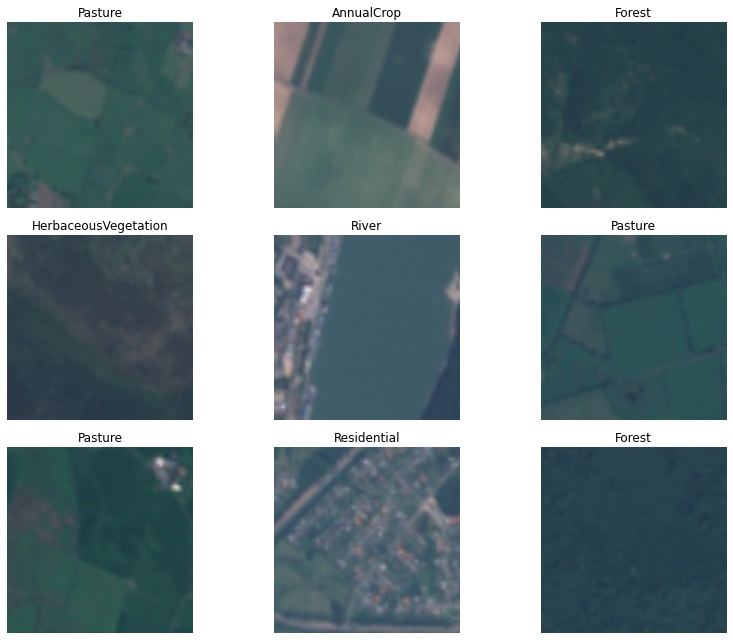

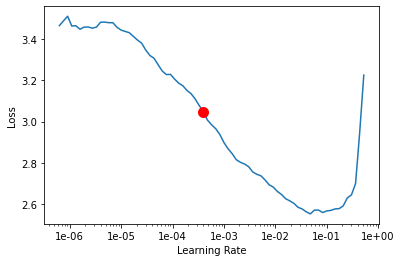

In [33]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : False, 
    "load_dir": None
}

vis = model.FastVision(models.resnet101, parameters, task="classification")
vis.find_alpha()


In [34]:
vis.fit_model_cyc(15, 5e-03)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 3.98E-05


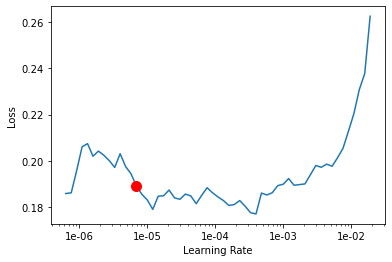

In [35]:
vis.find_alpha()

In [36]:
vis.learn.fit_one_cycle(10, max_lr=slice(5e-04))

In [37]:
vis.learn.save(base_dir / "learn" / "euro-res101-r")

In [38]:
interp = ClassificationInterpretation.from_learner(vis.learn) 

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs) # 해석에는 validatoin set 을 사용함

True

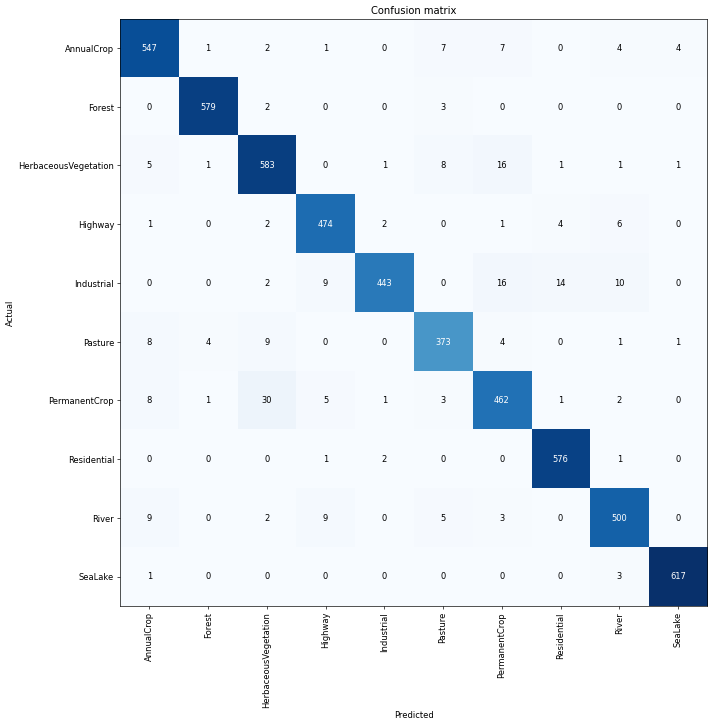

In [39]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [41]:
interp.most_confused(10)

[('PermanentCrop', 'HerbaceousVegetation', 30),
 ('HerbaceousVegetation', 'PermanentCrop', 16),
 ('Industrial', 'PermanentCrop', 16),
 ('Industrial', 'Residential', 14),
 ('Industrial', 'River', 10)]

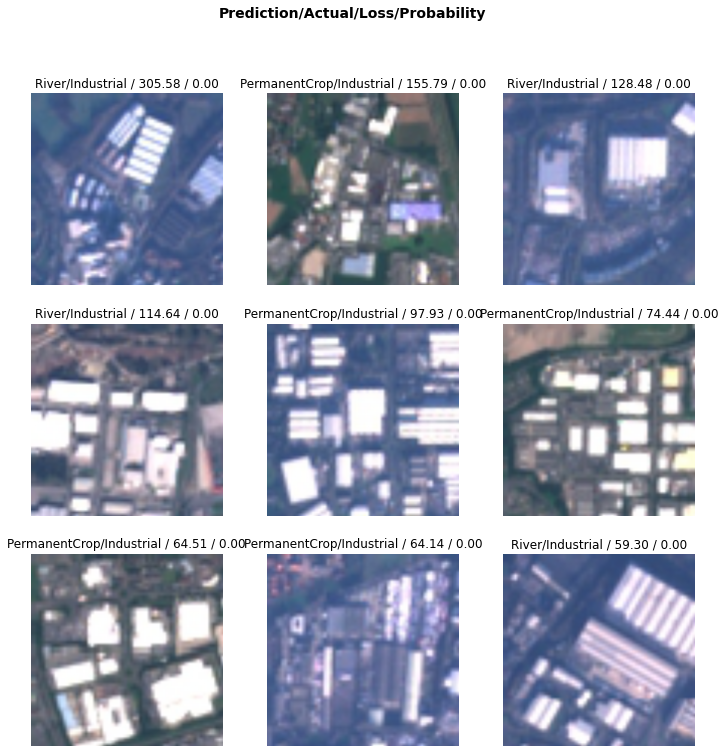

In [43]:
interp.plot_top_losses(9)

## 2.3. ResNet152

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

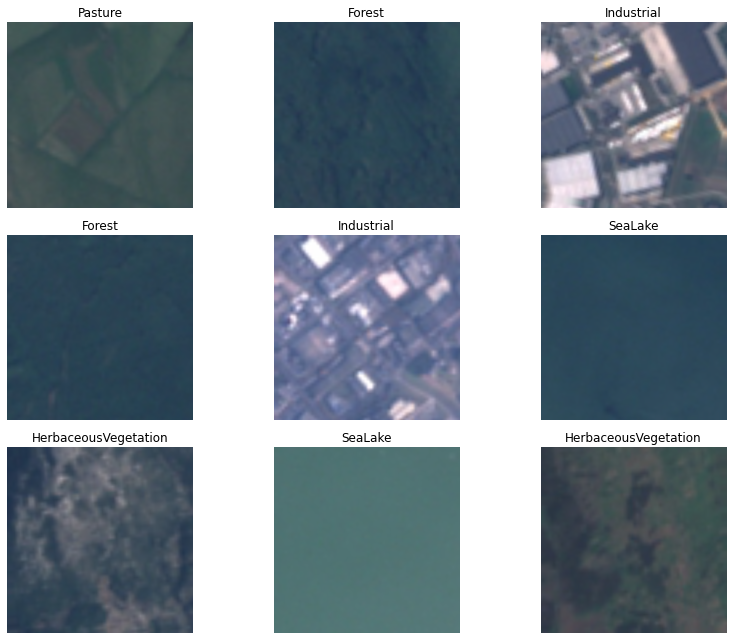

In [66]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy],
    "pretrained" : True, 
    "load_dir": None
}

vis = model.FastVision(models.resnet152, parameters, task="classification")
vis.find_alpha()


In [21]:
vis.learn.fit_one_cycle(15, 5e-03)

In [22]:
vis.learn.save(base_dir / "learn" / "euro-res152-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


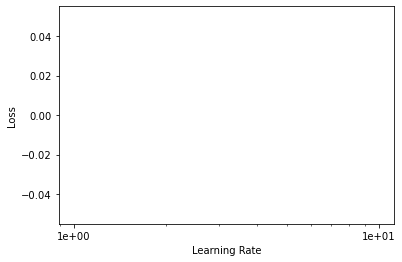

In [23]:
vis.learn.unfreeze()

vis.find_alpha()

In [24]:
vis.learn.fit_one_cycle(10, max_lr=slice(1e-04))
vis.learn.save(base_dir / "learn" / "euro-res152-2")

### Pretraining from Scratch

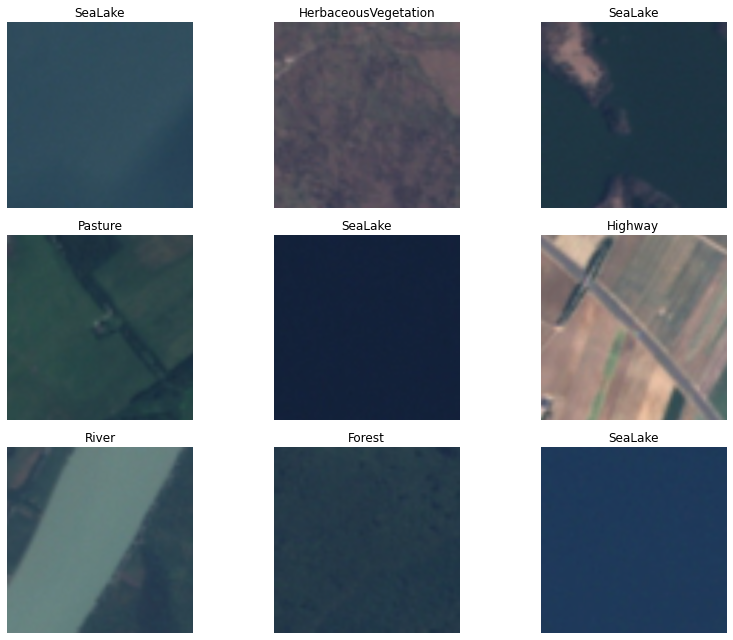

In [74]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : False, 
    "load_dir": None
}

vis = model.FastVision(models.resnet152, parameters, task="classification")

In [75]:
# import torch
# import torch.nn as nn


# vis.learn.model = torch.nn.DataParallel(vis.learn.model)
# vis.find_alpha()

In [76]:
vis.fit_model_cyc(15, 5e-03)

In [77]:
vis.learn.save(base_dir / "learn" / "euro-res152-r-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 1.10E-07


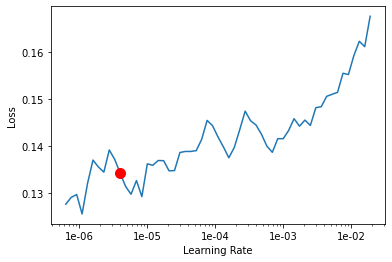

In [78]:
vis.find_alpha()

In [79]:
vis.learn.fit_one_cycle(10, max_lr=slice(1e-04))

In [80]:
vis.learn.save(base_dir / "learn" / "euro-res152-r-2")

## 2.4. ResNet34

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 1.20E-02


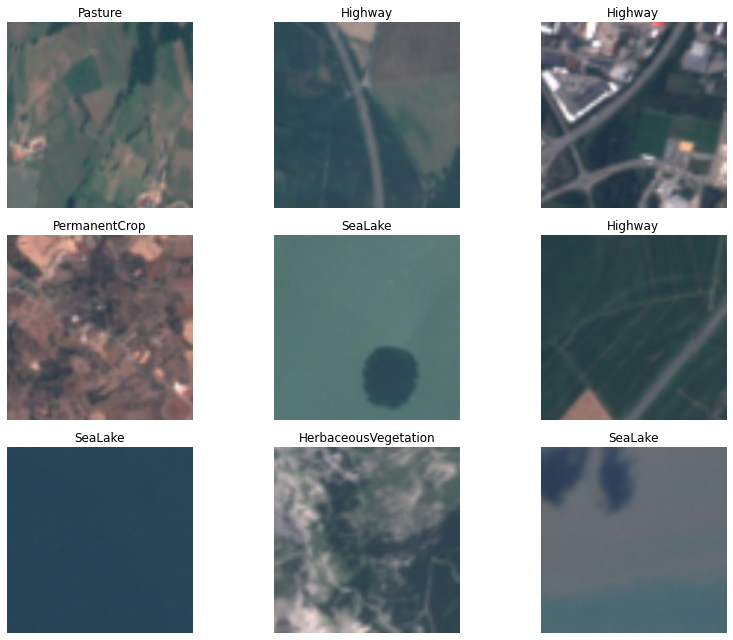

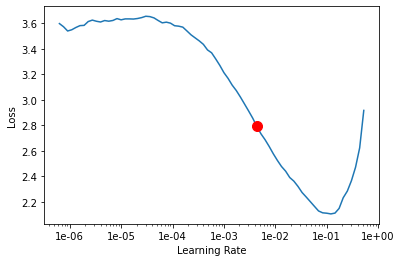

In [10]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : True, 
    "load_dir": None
}

vis = model.FastVision(models.resnet34, parameters, task="classification")
vis.find_alpha()


In [11]:
vis.learn.fit_one_cycle(15, 5e-03)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.31E-06


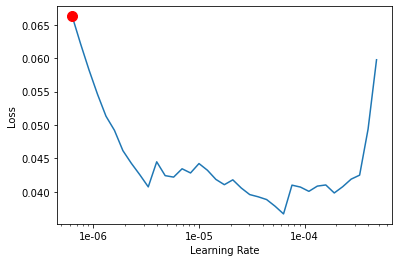

In [13]:
vis.learn.unfreeze()

vis.find_alpha()

In [14]:
vis.learn.fit_one_cycle(10, max_lr=slice(1e-04))
vis.learn.save(base_dir / "learn" / "euro-res34-2")

### Pretraining from Scratch

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 6.92E-03


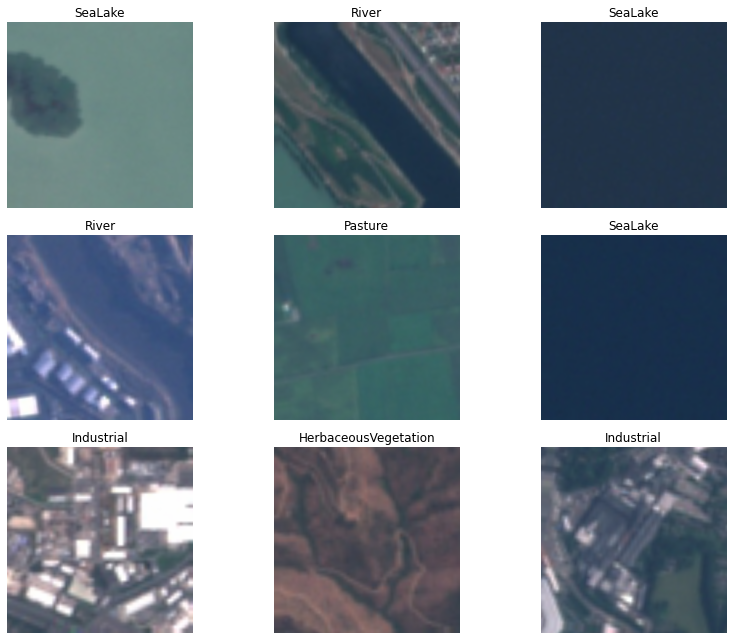

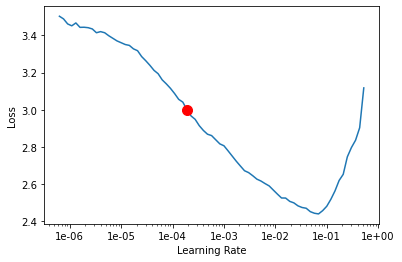

In [15]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : False, 
    "load_dir": None
}

vis = model.FastVision(models.resnet34, parameters, task="classification")
vis.find_alpha()


In [16]:
vis.learn.fit_one_cycle(15, 5e-03)
vis.learn.save(base_dir / "learn" / "euro-res34-r-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.98E-07


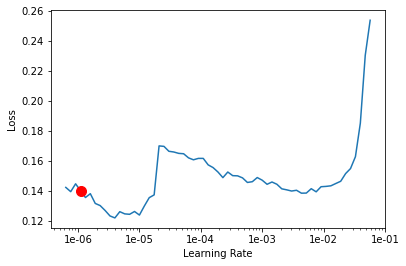

In [17]:
vis.find_alpha()

In [22]:
vis.learn.fit_one_cycle(10, max_lr=slice(1e-06, 5e-05))
vis.learn.save(base_dir / "learn" / "euro-res34-r-2")

# 3. Interpretation

In [9]:
parameters = {
    "path" : data_path / "eurosat",
    "bs" : 32, 
    "size" : 256, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy, f1_macro, f1_weighted],
    "pretrained" : True, 
    "load_dir": None
}

vis = model.FastVision(models.resnet50, parameters, task="classification")
# vis.find_alpha()


NameError: name 'f1_macro' is not defined

In [24]:
vis.learn.load(base_dir / "learn" / "euro-res50-r-2")

Learner(data=ImageDataBunch;

Train: LabelList (21600 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
AnnualCrop,AnnualCrop,AnnualCrop,AnnualCrop,AnnualCrop
Path: /home/jovyan/Land-Cls/data/eurosat;

Valid: LabelList (5400 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Highway,Residential,River,Highway,Forest
Path: /home/jovyan/Land-Cls/data/eurosat;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

In [25]:
interp = ClassificationInterpretation.from_learner(vis.learn) 

losses,idxs = interp.top_losses()

len(vis.learn.data.valid_ds)==len(losses)==len(idxs) # 해석에는 validatoin set 을 사용함

True

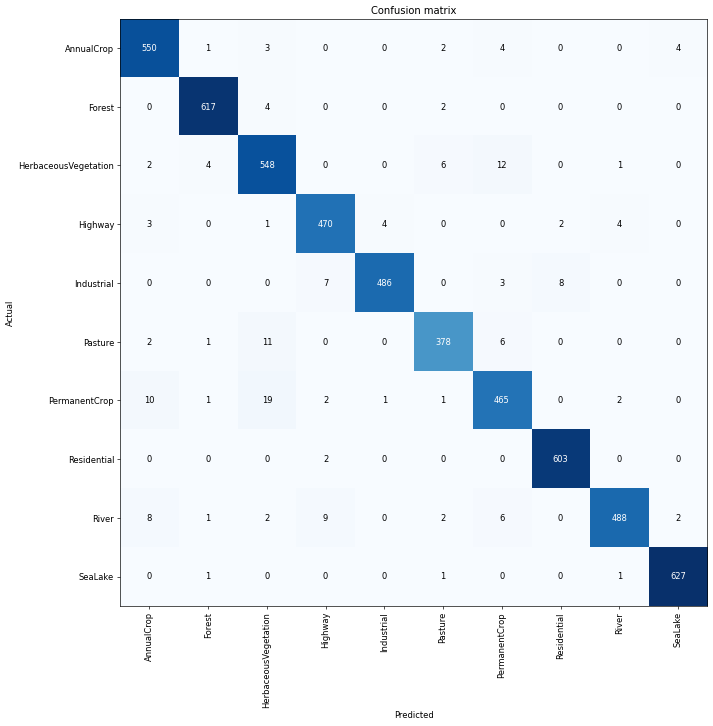

In [26]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

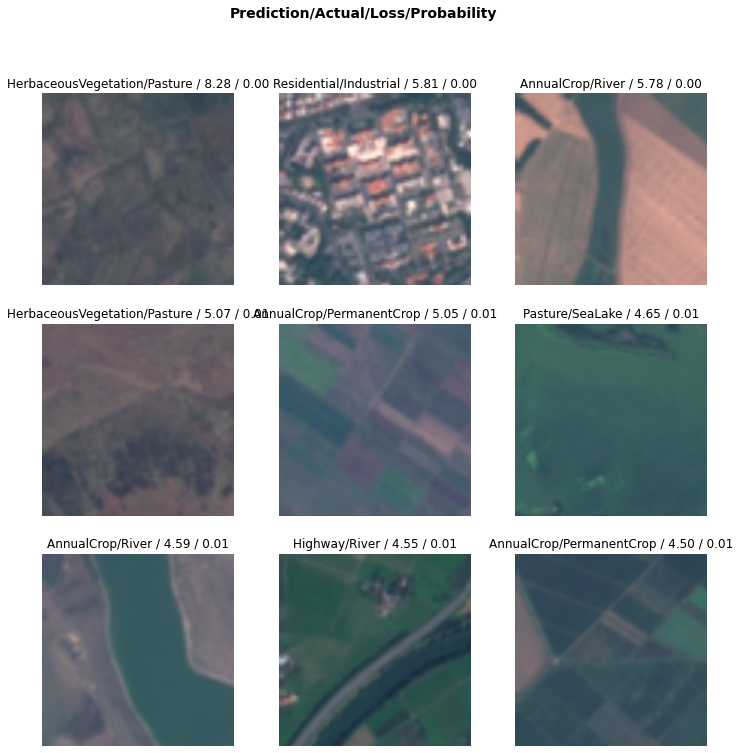

In [30]:
interp.plot_top_losses(9)

In [35]:
interp.most_confused(2)

[('PermanentCrop', 'HerbaceousVegetation', 19),
 ('HerbaceousVegetation', 'PermanentCrop', 12),
 ('Pasture', 'HerbaceousVegetation', 11),
 ('PermanentCrop', 'AnnualCrop', 10),
 ('River', 'Highway', 9),
 ('Industrial', 'Residential', 8),
 ('River', 'AnnualCrop', 8),
 ('Industrial', 'Highway', 7),
 ('HerbaceousVegetation', 'Pasture', 6),
 ('Pasture', 'PermanentCrop', 6),
 ('River', 'PermanentCrop', 6),
 ('AnnualCrop', 'PermanentCrop', 4),
 ('AnnualCrop', 'SeaLake', 4),
 ('Forest', 'HerbaceousVegetation', 4),
 ('HerbaceousVegetation', 'Forest', 4),
 ('Highway', 'Industrial', 4),
 ('Highway', 'River', 4),
 ('AnnualCrop', 'HerbaceousVegetation', 3),
 ('Highway', 'AnnualCrop', 3),
 ('Industrial', 'PermanentCrop', 3),
 ('AnnualCrop', 'Pasture', 2),
 ('Forest', 'Pasture', 2),
 ('HerbaceousVegetation', 'AnnualCrop', 2),
 ('Highway', 'Residential', 2),
 ('Pasture', 'AnnualCrop', 2),
 ('PermanentCrop', 'Highway', 2),
 ('PermanentCrop', 'River', 2),
 ('Residential', 'Highway', 2),
 ('River', 'Herb

In [ ]:
#     self.learn.model = nn.DataParallel(self.learn.model)

In [21]:
!free -g
!ls /home/jovyan/Land-Cls/data/bigearth/image -l | wc -l
# !ls image -l | wc -l

              total        used        free      shared  buff/cache   available
Mem:            251          62         173           1          15         185
Swap:             0           0           0
446605
